In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import copy
import folium
import re
from statistics import mean, stdev

In [3]:
#CARGA DE DATOS
#Se reutiliza el código de carga de datos del proyecto anterior

def load_distance_time_dic(path):
    data = pd.read_csv(path)
    distance = {}
    time = {}
    for i in range(len(data)):
        origen = int(data.iloc[i, 0])
        destino = int(data.iloc[i, 1])
        distance[origen, destino] = float(data.iloc[i, 2])/1000
        time[origen, destino] = float(data.iloc[i, 3])
    return distance, time
5
def load_vehicles(path):
    data = pd.read_csv(path)
    vehicles = {}
    for i in range(len(data)):
        id = int(data.iloc[i, 0])
        capacity = int(data.iloc[i, 1])
        ran = float(data.iloc[i, 2])
        vehicles[id] = (capacity, ran)
    return vehicles

def load_demand(path):
    data = pd.read_csv(path)
    demand_dic = {}
    for i in range(len(data)):
        id = int(data.iloc[i, 1])
        demand = float(data.iloc[i, 2])
        demand_dic[id] = demand
    return demand_dic

def load_coordinates(depotsPath, clientsPath):
    coord = {}
    depot = pd.read_csv(depotsPath)
    client = pd.read_csv(clientsPath)
    for i in range(len(depot)):
        id = int(depot.iloc[i, 1])
        lat = float(depot.iloc[i, 3])
        long = float(depot.iloc[i, 2])
        coord[id] = [lat, long]
    for j in range(len(client)):
        id = int(client.iloc[j, 1])
        lat = float(client.iloc[j, 4])
        long = float(client.iloc[j, 3])
        coord[id] = [lat, long]
    return coord


In [4]:
distancia,time_dic = load_distance_time_dic('../Datos/casoBase.csv')
vehiculos = load_vehicles('../Datos/vehicles.csv')
demanda = load_demand('../Datos/clients.csv')
coord = load_coordinates('../Datos/depots.csv', '../Datos/clients.csv')
print(f"Distancia: {distancia}")
print(f"Vehiculos: {vehiculos}")
print(f"Demanda: {demanda}")
print(f"Coordenadas: {coord}")
print(f"Time: {time_dic}")



Distancia: {(1, 2): 27.144299999999998, (1, 3): 17.6771, (1, 4): 13.9796, (1, 5): 26.6508, (1, 6): 22.5837, (1, 7): 18.5625, (1, 8): 24.765900000000002, (1, 9): 23.9294, (1, 10): 27.835900000000002, (1, 11): 33.6518, (1, 12): 31.029400000000003, (1, 13): 16.1247, (1, 14): 21.6122, (1, 15): 10.3874, (1, 16): 27.040200000000002, (1, 17): 33.9631, (1, 18): 26.5413, (1, 19): 20.0532, (1, 20): 21.278200000000002, (1, 21): 13.411200000000001, (1, 22): 27.8695, (1, 23): 24.2626, (1, 24): 11.364799999999999, (1, 25): 30.8098, (2, 1): 30.809900000000003, (2, 3): 14.2563, (2, 4): 19.400299999999998, (2, 5): 1.1309, (2, 6): 12.475100000000001, (2, 7): 11.4167, (2, 8): 16.8514, (2, 9): 13.820799999999998, (2, 10): 7.5098, (2, 11): 7.110399999999999, (2, 12): 10.8902, (2, 13): 24.4451, (2, 14): 7.9738999999999995, (2, 15): 20.1425, (2, 16): 1.2554, (2, 17): 7.4218, (2, 18): 4.283399999999999, (2, 19): 9.819600000000001, (2, 20): 15.2813, (2, 21): 23.0465, (2, 22): 21.1477, (2, 23): 5.482, (2, 24): 

In [5]:
# Parámetros
depot_id = 1  # depósito con demanda 0
pf = 15000
ft = 5000
cm = 700
gv = 0.411458



def evaluar_individuo(rutas, demanda, vehiculos, distancia, pf, ft, cm, gv):
    claves_vehiculos = list(vehiculos.keys())
    total_cost = 0
    for v_id, ruta in enumerate(rutas):
        if len(ruta) <= 2:
            continue
        cap_max, rango_max = vehiculos[claves_vehiculos[v_id]]
        carga = 0
        distancia_total = 0

        for i in range(len(ruta) - 1):
            a, b = ruta[i], ruta[i+1]
            distancia_total += distancia.get((a, b), 9999999)
            if b != depot_id:
                carga += demanda.get(b, 0)

        penalizacion = 0
        if carga > cap_max:
            penalizacion += 1e6 * (carga - cap_max)
        if distancia_total > rango_max:
            penalizacion += 1e6 * (distancia_total - rango_max)

        costo_vehiculo = gv*pf * distancia_total + ft + cm + penalizacion
        total_cost += costo_vehiculo
    return total_cost

def generar_poblacion_inicial(n_individuos, clientes, vehiculos):
    poblacion = []
    n_vehiculos = len(vehiculos)
    for _ in range(n_individuos):
        rutas = [[] for _ in vehiculos]
        clientes_copy = clientes[:]
        random.shuffle(clientes_copy)
        # Asignar cada cliente exactamente a un vehículo
        for idx, c in enumerate(clientes_copy):
            v_id = idx % n_vehiculos  # asignación round robin para mejor distribución
            rutas[v_id].append(c)
        # Agregar depósito al inicio y fin de cada ruta
        rutas = [[depot_id] + r + [depot_id] if r else [] for r in rutas]
        poblacion.append(rutas)
    return poblacion

def mutar(rutas):
    nuevas = copy.deepcopy(rutas)
    # Elegir dos vehículos distintos
    v1, v2 = random.sample(range(len(rutas)), 2)
    if len(nuevas[v1]) > 2:
        cliente = random.choice(nuevas[v1][1:-1])
        nuevas[v1].remove(cliente)
        # Insertar cliente en una posición aleatoria en v2, excepto el depósito final
        pos = random.randint(1, len(nuevas[v2]) - 1) if len(nuevas[v2]) > 0 else 1
        nuevas[v2].insert(pos, cliente)
    return nuevas

def cruzar(p1, p2):
    hijo = copy.deepcopy(p1)
    v = random.randint(0, len(p1) - 1)
    if len(p1[v]) > 2 and len(p2[v]) > 2:
        sub1 = p1[v][1:-1]
        sub2 = p2[v][1:-1]
        split = len(sub1) // 2
        nuevo = [depot_id] + sub1[:split] + sub2[split:] + [depot_id]
        # Para evitar duplicados/remover clientes fuera de esta ruta,
        # hacemos limpieza después del cruce
        hijo[v] = nuevo

        # Extraer clientes asignados en la nueva ruta
        asignados = set(nuevo[1:-1])

        # Eliminar estos clientes de otras rutas para evitar duplicados
        for i in range(len(hijo)):
            if i != v:
                hijo[i] = [depot_id] + [c for c in hijo[i][1:-1] if c not in asignados] + [depot_id]

        # Insertar los clientes que quedaron fuera en la ruta v de forma aleatoria
        todos_clientes = set(c for ruta in p1 for c in ruta[1:-1])
        fuera = todos_clientes - asignados
        for c in fuera:
            pos = random.randint(1, len(hijo[v]) - 1)
            hijo[v].insert(pos, c)
    return hijo

def nodos_no_asignados(rutas, clientes, depot_id):
    asignados = set()
    for ruta in rutas:
        asignados.update(n for n in ruta if n != depot_id)
    no_asignados = set(clientes) - asignados
    return no_asignados

def run_ga(distance, demand, vehicles, coord, n_generaciones=200, n_poblacion=50, elitismo=5, prob_mutacion=0.2):
    demanda[depot_id] = 0
    clientes = [c for c in demand.keys() if c != depot_id]
    poblacion = generar_poblacion_inicial(n_poblacion, clientes, vehicles)
    best_indiv = []
    for gen in range(n_generaciones):
        puntuaciones = [(evaluar_individuo(ind, demand, vehicles, distance, pf, ft, cm, gv), ind) for ind in poblacion]
        puntuaciones.sort(key=lambda x: x[0])
        best_indiv.append(puntuaciones[0][0])
        elite = [ind for (_, ind) in puntuaciones[:elitismo]]

        nueva_poblacion = elite[:]
        while len(nueva_poblacion) < n_poblacion:
            p1, p2 = random.choices(elite, k=2)
            hijo = cruzar(p1, p2)
            if random.random() < prob_mutacion:
                hijo = mutar(hijo)
            # Validar que no haya nodos sin asignar, si hay los añadimos manualmente
            faltantes = nodos_no_asignados(hijo, clientes, depot_id)
            if faltantes:
                # Añadir faltantes a rutas aleatorias
                for f in faltantes:
                    v_id = random.randint(0, len(vehicles) -1)
                    # Insertar antes del depósito final
                    hijo[v_id].insert(-1, f)
            nueva_poblacion.append(hijo)

        poblacion = nueva_poblacion

    mejor_coste, mejor_sol = min([(evaluar_individuo(ind, demand, vehicles, distance, pf, ft, cm, gv), ind) for ind in poblacion], key=lambda x: x[0])

    faltantes_final = nodos_no_asignados(mejor_sol, clientes, depot_id)
    if faltantes_final:
        print("Algunos nodos no fueron asignados en la mejor solución:", faltantes_final)
    else:
        print("Todos los nodos fueron asignados correctamente.")

    print("Mejor costo:", mejor_coste)
    return mejor_sol, best_indiv



In [6]:
def visualizar_rutas_folium(rutas, coord):
    # Crear mapa centrado en depósito o promedio de coordenadas
    lat_dep, lon_dep = coord[depot_id]
    m = folium.Map(location=[lat_dep, lon_dep], zoom_start=11, tiles='Cartodb Positron')

    colors = ['blue', 'green', 'cyan', 'magenta','olive', 'blue', 'orange', 'purple','red']
    icons = ['blue', 'green', 'lightblue', 'pink','lightgreen', 'blue', 'orange', 'darkpurple','red']

    for v, ruta in enumerate(rutas):
        if not ruta or len(ruta) < 2:
            continue

        # Construir lista de coordenadas para PolyLine: [(lat, lon), (lat, lon), ...]
        coords_ruta = [coord[n] for n in ruta]

        # Dibujar la ruta
        folium.PolyLine(
            coords_ruta,
            color=colors[v % len(colors)],
            weight=5,
            opacity=0.7,
            tooltip=f'Vehículo {v}'
        ).add_to(m)

        # Marcador inicio (depósito)
        folium.Marker(
            coords_ruta[0],
            popup="Inicio (Depósito)",
            icon=folium.Icon(color='black', icon='home')
        ).add_to(m)

        # Marcador fin de ruta
        folium.Marker(
            coords_ruta[-1],
            popup=f"Llegada Vehículo {v}",
            icon=folium.Icon(color=icons[v % len(icons)], icon='flag')
        ).add_to(m)

    return m


In [7]:
solucion, evol = run_ga(distancia, demanda, vehiculos, coord, n_generaciones=300, n_poblacion=50, elitismo=5, prob_mutacion=0.7)
mapa = visualizar_rutas_folium(solucion, coord)
mapa

Todos los nodos fueron asignados correctamente.
Mejor costo: 3396651.3789719995


## Visualización y estadísticas

In [32]:

def isClient(name):
    return bool(re.fullmatch(r'C\d+', name))

#SIN TERMINAR
def generateValidationFile(rutas, vehiculos, clientes):
    data = {
    'VehicleId':[] ,
    'DepotId':[] ,
    'InitialLoad':[] ,
    'RouteSequence':[] ,
    'ClientsServed':[] ,
    'DemandsSatisfied':[] , 
    'TotalDistance':[] , 
    'TotalTime':[] , 
    'FuelCost':[]
    }
    for ruta in rutas:
        print('r', ruta)
    for v in vehiculos:
        path = []
    
        print('v', v)
        data['VehicleId'].append("VEH" + "{:03d}".format(v))
        clients = 0
        demandas = []
        total_demand = 0
        for nodo in rutas[v-1]:
            if nodo == 1:
                path.append('CD1')
            else:
                path.append('C' + str(nodo))
                clients += 1
                demanda_c = demanda[nodo]
                print(demanda_c)
                demandas.append(str(demanda_c))
                total_demand += demanda_c
        print(demandas)
        data['RouteSequence'].append("-".join(path))
        data['ClientsServed'].append(clients)
        data['DepotId'].append('CD1')
        data['DemandsSatisfied'].append("-".join(demandas))
        data['InitialLoad'].append(total_demand)

        
        total_dist = 0
        t_time = 0
        ruta = rutas[v-1]
        for i in range(len(ruta) -1):
            total_dist += distancia[(ruta[i],ruta[i+1])]
            t_time += time_dic[(ruta[i],ruta[i+1])]
        t_time = t_time/60
        print(total_dist)
        print(t_time)



        data['TotalDistance'].append(round(total_dist,1))
        data['TotalTime'].append(round(t_time, 1))
        data['FuelCost'].append(round((total_dist)*pf))
        #print("time", t_time)

    print(data)
    df = pd.DataFrame(data)
    df.to_csv("verificacion_casoBase_metaheuristica_1.csv", index=False)
    
generateValidationFile(solucion, vehiculos, demanda)   

#print(data)

r [1, 13, 4, 21, 1]
r [1, 8, 22, 9, 1]
r [1, 5, 16, 12, 1]
r [1, 19, 10, 2, 1]
r [1, 24, 11, 18, 1]
r [1, 25, 17, 14, 1]
r [1, 7, 3, 20, 1]
r [1, 15, 6, 23, 1]
v 1
12.0
12.0
15.0
['12.0', '12.0', '15.0']
42.3403
70.21833333333333
v 2
17.0
14.0
20.0
['17.0', '14.0', '20.0']
88.2654
130.185
v 3
15.0
17.0
17.0
['15.0', '17.0', '17.0']
75.1276
100.94666666666666
v 4
12.0
20.0
13.0
['12.0', '20.0', '13.0']
69.2765
107.195
v 5
15.0
15.0
25.0
['15.0', '15.0', '25.0']
73.5208
112.05833333333334
v 6
11.0
10.0
21.0
['11.0', '10.0', '21.0']
72.4534
111.33333333333333
v 7
17.0
15.0
11.0
['17.0', '15.0', '11.0']
56.1671
87.81333333333333
v 8
15.0
20.0
18.0
['15.0', '20.0', '18.0']
65.80449999999999
97.17666666666668
{'VehicleId': ['VEH001', 'VEH002', 'VEH003', 'VEH004', 'VEH005', 'VEH006', 'VEH007', 'VEH008'], 'DepotId': ['CD1', 'CD1', 'CD1', 'CD1', 'CD1', 'CD1', 'CD1', 'CD1'], 'InitialLoad': [39.0, 51.0, 49.0, 45.0, 55.0, 42.0, 43.0, 53.0], 'RouteSequence': ['CD1-C13-C4-C21-CD1', 'CD1-C8-C22-C9-CD

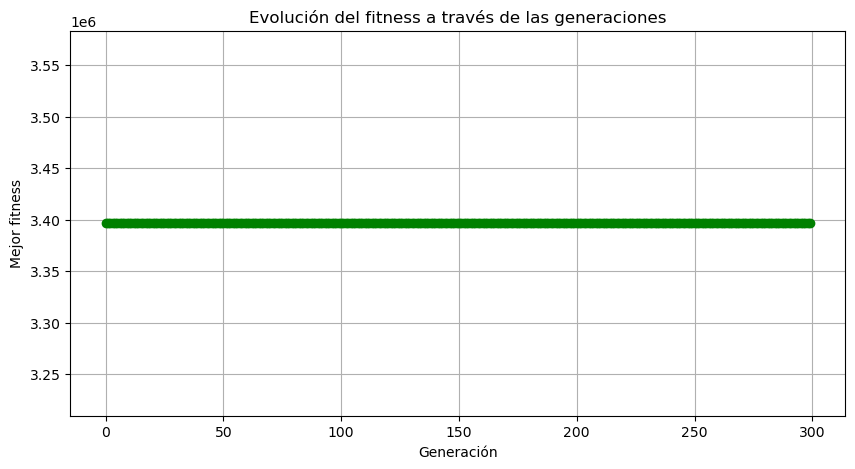

Costo total: 3396651.3789719995
Costo promedio por vehículo: 424581.42237149994
Desviación estándar de costos: 79175.49985637369


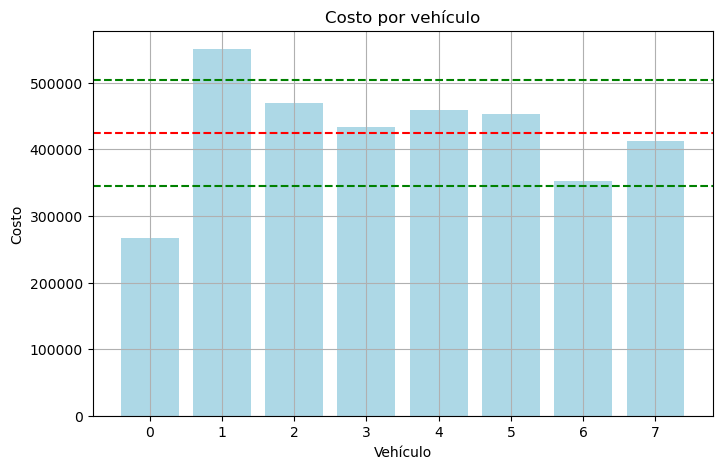

In [16]:

def graficar_costos_por_vehiculo(rutas, distancia, pf, ft, cm, gv):
    costos =[]
    for ruta in rutas:
        distance = 0
        for i in range(len(ruta)-1):
            distance += distancia[(ruta[i], ruta[i+1])]
        costo = gv*pf * distance + ft + cm
        costos.append(costo)
    media =  np.mean(costos)
    dev_est = np.std(costos) 
    print("Costo total:", sum(costos))
    print("Costo promedio por vehículo:", media)
    print("Desviación estándar de costos:", dev_est)

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(costos)), costos, color='lightblue')
    plt.axhline(y=media, color='r', linestyle='dashed')
    plt.axhline(y=media+dev_est, color='g', linestyle='dashed')
    plt.axhline(y=media-dev_est, color='g', linestyle='dashed')
    plt.xlabel('Vehículo')
    plt.ylabel('Costo')
    plt.title('Costo por vehículo')
    plt.grid(True)
    plt.show()


def graficar_evolucion_fitness(mejores_costos):
    plt.figure(figsize=(10, 5))
    plt.plot(mejores_costos, marker='o', color='green')
    plt.xlabel('Generación')
    plt.ylabel('Mejor fitness')
    plt.title('Evolución del fitness a través de las generaciones')
    plt.grid(True)
    plt.show()

graficar_evolucion_fitness(evol)
graficar_costos_por_vehiculo(solucion, distancia, pf, ft, cm, gv)


## Analisis de Escalabilidad

## Comparación son soluciones previas (Pyomo)